In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 17:10:53 2020

@author: wanxiang.shen@u.nus.edu
"""

import warnings, os
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
from glob import glob

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.metrics import auc as calculate_auc
from joblib import load, dump
import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggModel, loadmap
from aggmap import show
np.random.seed(666) #just for reaptable results


from tqdm import tqdm

tqdm.pandas(ascii=True)

In [2]:
def gauss_noisy(X, c = 0.38):
    ''' 
    X: 4D array, n,w,h,c
    '''
    np.random.seed(123)
    
    X = np.clip(X + np.random.normal(size = X.shape, scale = c), 0, 1)
    return X

In [3]:
dfx  = pd.read_excel('./COVID19.xlsx', sheet_name='data')
dfy  = pd.read_excel('./COVID19.xlsx', sheet_name='sample_info')
mp = loadmap('./saved_model/aggmap.mp')

scale_method = 'standard'


dfx = dfx[dfx.columns[1:]]
cols = ["p-%s" % c for c in dfx.columns]
dfx.columns = cols

X = mp.batch_transform(dfx.values, scale_method= scale_method)
Y = pd.get_dummies(dfy['class']).values.astype(float)

100%|##########| 362/362 [00:02<00:00, 149.23it/s]


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler = scaler.fit(dfx)
dfscale = pd.DataFrame(scaler.transform(dfx), index = dfx.index, columns=dfx.columns)

In [6]:
data_save_folder = '/raid/shenwanxiang/COVID-19/COV-C'

if not os.path.exists(data_save_folder):
    os.makedirs(data_save_folder)
    
stddevs = np.arange(0, 0.5, 0.08)

X_noisys_1 = []
X_noisys_5 = []

n, w, h, c = X.shape

for stddev in stddevs:

    dfscale_noise = gauss_noisy(dfscale, c=stddev)
    dfx_noise = pd.DataFrame(scaler.inverse_transform(dfscale_noise))
    X5_n = mp.batch_transform(dfx_noise.values, scale_method= scale_method)

    X1_n = X5_n.sum(axis=-1).reshape(n, w, h, 1)
    
    X_noisys_5.append(X5_n)
    X_noisys_1.append(X1_n)
    
dump(X_noisys_5,  os.path.join(data_save_folder, 'Agg5_noisys.data')) 
dump(X_noisys_1,  os.path.join(data_save_folder, 'Agg1_noisys.data')) 

100%|##########| 362/362 [00:00<00:00, 2990.56it/s]


['/raid/shenwanxiang/COVID-19/COV-C/Agg1_noisys.data']

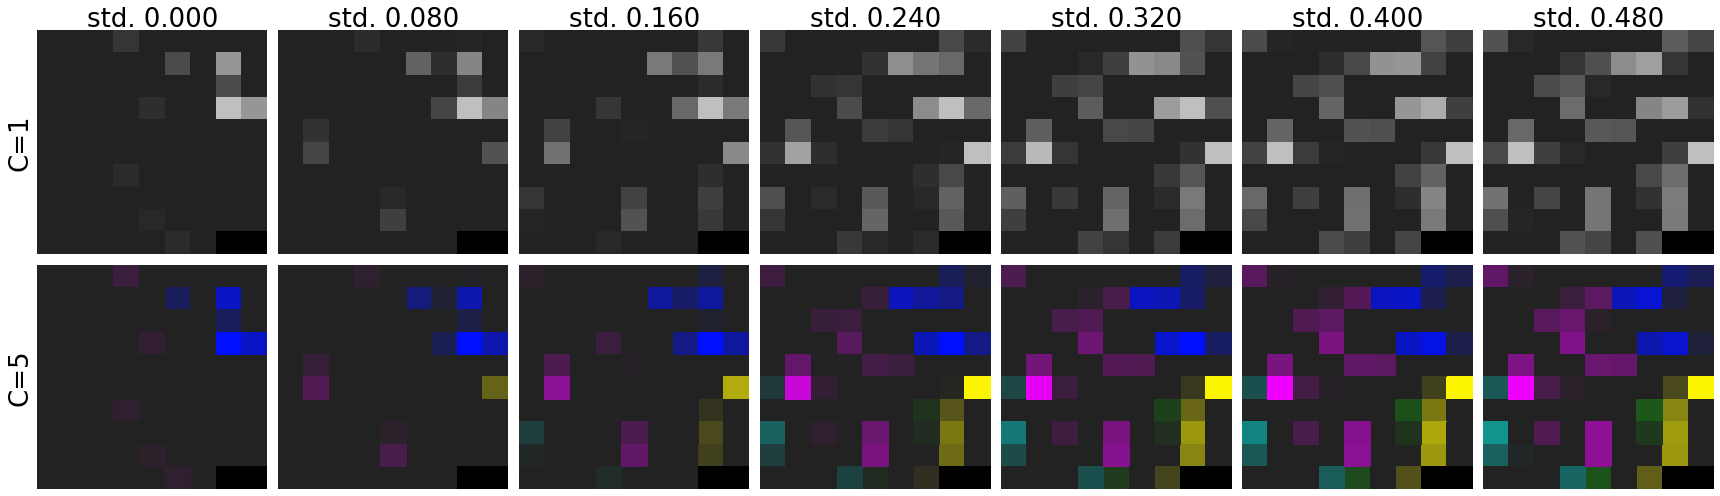

In [22]:
rows = ['std. %.3f' % i for i in stddevs]
fontsize = 26
fig, axes = plt.subplots(nrows=2, ncols=len(rows), figsize=(24, 7), sharex = False, sharey = False)


X1 = [X_noisys_1[i][0] for i in range(len(rows))]
X2 = [X_noisys_5[i][0] for i in range(len(rows))]
X1.extend(X2)

for x, ax in zip(X1, axes.ravel()):
    
    
    #ax.imshow(x.sum(axis=-1))
    if x.shape[-1] == 1:
        #ax.imshow(x.reshape(w, h), cmap = 'gray')
        #ax.set_xticks([])
        #ax.set_yticks([])
        show.imshow(x.reshape(w, h, 1), ax = ax,  mode = 'dark', color_list= ['#bfbfbf'],   x_max=1, vmin=0.2, vmax=x.max()-0.8 )
        
    else:
        show.imshow(x, ax = ax,  mode = 'dark', color_list= pd.Series(mp.colormaps).tolist(),  x_max=1, vmin=0.2, vmax=x.max()-0.8) # vmax=x.max()
    
    #

for ax, name in zip(axes[0, :], rows):
    ax.set_xlabel(name, fontsize = fontsize) 
    ax.xaxis.set_label_position('top') 

for ax, name in zip(axes[0:2, 0], ['C=1', 'C=5']):
    ax.set_ylabel(name, fontsize = fontsize) 

    
fig.tight_layout()

fig.savefig('./noise-fmp-1-5.png', bbox_inches='tight', dpi=400) 
# fig.savefig('./fmp.svg', bbox_inches='tight', dpi=400) 